In [1]:
# --- CELL 1: Imports & Configuration ---
import json
import joblib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch (Deep Learning)
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-Learn (Validation & Metrics)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle

# Configuration
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Step 1: Data Engineering

In [2]:
# --- CELL 2: Data Loading & Feature Engineering ---
DATA_PATH = 'PS_20174392719_1491204439457_log.csv'

if not os.path.exists(DATA_PATH):
    print(f"⚠️ Dataset not found at {DATA_PATH}. Please download 'PaySim' from Kaggle.")
else:
    print("Loading dataset...")
    df = pd.read_csv(DATA_PATH)

    # 1. Log Transform for Skewed Amount
    df['amount_log'] = np.log1p(df['amount'])

    # 2. Cyclical Time Features
    df['hour'] = df['step'] % 24
    df['hr_sin'] = np.sin(2 * np.pi * df['hour'] / 23)
    df['hr_cos'] = np.cos(2 * np.pi * df['hour'] / 23)

    # 3. Create Balanced Dataset (50% Fraud / 50% Non-Fraud)
    fraud = df[df['isFraud'] == 1]
    normal = df[df['isFraud'] == 0].sample(n=len(fraud), random_state=42)
    balanced_df = pd.concat([fraud, normal])
    balanced_df = shuffle(balanced_df, random_state=42)

    # 4. Scale Data (-1 to 1 for GAN stability)
    cols_to_fit = ['amount_log', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'hr_sin', 'hr_cos', 'isFraud']
    scaler = MinMaxScaler(feature_range=(-1, 1))
    final_data = scaler.fit_transform(balanced_df[cols_to_fit])

    print(f"✅ Data processed. Training shape: {final_data.shape}")

Loading dataset...
✅ Data processed. Training shape: (6786, 8)


## Step 2: Custom GAN Architecture

In [3]:
# --- CELL 3: Generator & Discriminator Classes ---
LATENT_DIM = 100
DATA_DIM = final_data.shape[1]

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, DATA_DIM),
            nn.Tanh() # Outputs -1 to 1
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(DATA_DIM, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize
generator = Generator().to(device)
discriminator = Discriminator().to(device)
print("✅ Models initialized.")

✅ Models initialized.


## Step 3: Training the GAN

In [4]:
# --- CELL 4: Training Loop ---
criterion = nn.BCELoss()
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    torch.FloatTensor(final_data), batch_size=batch_size, shuffle=True
)

NUM_EPOCHS = 100 # Adjust to 200-300 if needed for better results
print(f"Starting training for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):
    for i, real_data in enumerate(train_loader):
        current_batch_size = real_data.size(0)
        real_data = real_data.to(device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        real_labels = torch.ones(current_batch_size, 1).to(device)
        output_real = discriminator(real_data)
        loss_D_real = criterion(output_real, real_labels)

        noise = torch.randn(current_batch_size, LATENT_DIM).to(device)
        fake_data = generator(noise)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)
        output_fake = discriminator(fake_data.detach())
        loss_D_fake = criterion(output_fake, fake_labels)

        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()

        # --- Train Generator ---
        optimizer_G.zero_grad()
        output_g = discriminator(fake_data)
        loss_G = criterion(output_g, real_labels) # Trick D into thinking fake is real
        loss_G.backward()
        optimizer_G.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

print("✅ Training complete.")

Starting training for 100 epochs...
Epoch [20/100] | D Loss: 1.3496 | G Loss: 0.7540
Epoch [40/100] | D Loss: 1.3930 | G Loss: 0.8110
Epoch [60/100] | D Loss: 1.0576 | G Loss: 1.1156
Epoch [80/100] | D Loss: 1.2655 | G Loss: 0.8259
Epoch [100/100] | D Loss: 1.1998 | G Loss: 1.0373
✅ Training complete.


## Step 4: Generating the Synthetic Dataset

In [5]:
# --- CELL 5: Generate Synthetic Data ---
num_samples = len(balanced_df)
noise = torch.randn(num_samples, LATENT_DIM).to(device)

with torch.no_grad():
    fake_data_scaled = generator(noise).cpu().numpy()

# Inverse transform to get back original units ($)
synthetic_df = pd.DataFrame(scaler.inverse_transform(fake_data_scaled), columns=cols_to_fit)

# Clean up types for analysis
synthetic_df['isFraud'] = synthetic_df['isFraud'].round().astype(int)
print("✅ Synthetic dataset generated.")
print(synthetic_df['isFraud'].value_counts())

✅ Synthetic dataset generated.
isFraud
1    3423
0    3363
Name: count, dtype: int64


## Step 5: Privacy Check (DCR Analysis)

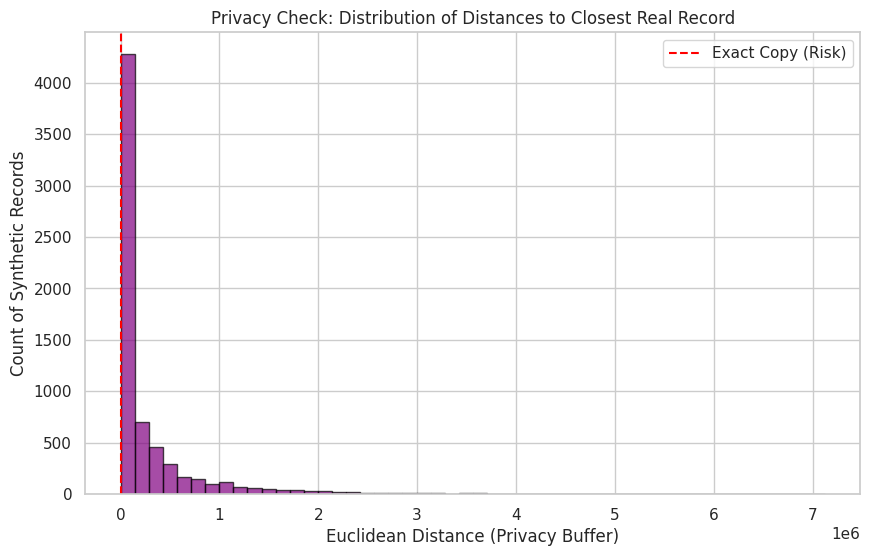

Minimum Distance to Real Data: 0.04530542329581344
✅ SUCCESS: No exact copies found. Privacy preserved.


In [6]:
# --- CELL 6: Privacy Validation (Distance to Closest Record) ---
def calculate_privacy_metric(real_data, synthetic_data, numerical_columns):
    """
    Calculates Distance to Closest Record (DCR) to ensure the GAN isn't just memorizing data.
    """
    # Fit Nearest Neighbor on REAL data
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    nn.fit(real_data[numerical_columns])

    # Find closest real neighbor for every synthetic point
    distances, indices = nn.kneighbors(synthetic_data[numerical_columns])

    # Plot
    plt.figure(figsize=(10, 6))
    plt.hist(distances, bins=50, alpha=0.7, color='purple', edgecolor='black')
    plt.title("Privacy Check: Distribution of Distances to Closest Real Record")
    plt.xlabel("Euclidean Distance (Privacy Buffer)")
    plt.ylabel("Count of Synthetic Records")
    plt.axvline(x=0, color='red', linestyle='--', label='Exact Copy (Risk)')
    plt.legend()
    plt.show()

    min_dist = np.min(distances)
    print(f"Minimum Distance to Real Data: {min_dist}")

    if min_dist > 0.0001:
        print("✅ SUCCESS: No exact copies found. Privacy preserved.")
    else:
        print("⚠️ WARNING: Exact copies detected. GAN may be overfitting.")

# Run Check
check_cols = ['amount_log', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
calculate_privacy_metric(balanced_df, synthetic_df, check_cols)

## Step 6: Visual Distribution Check

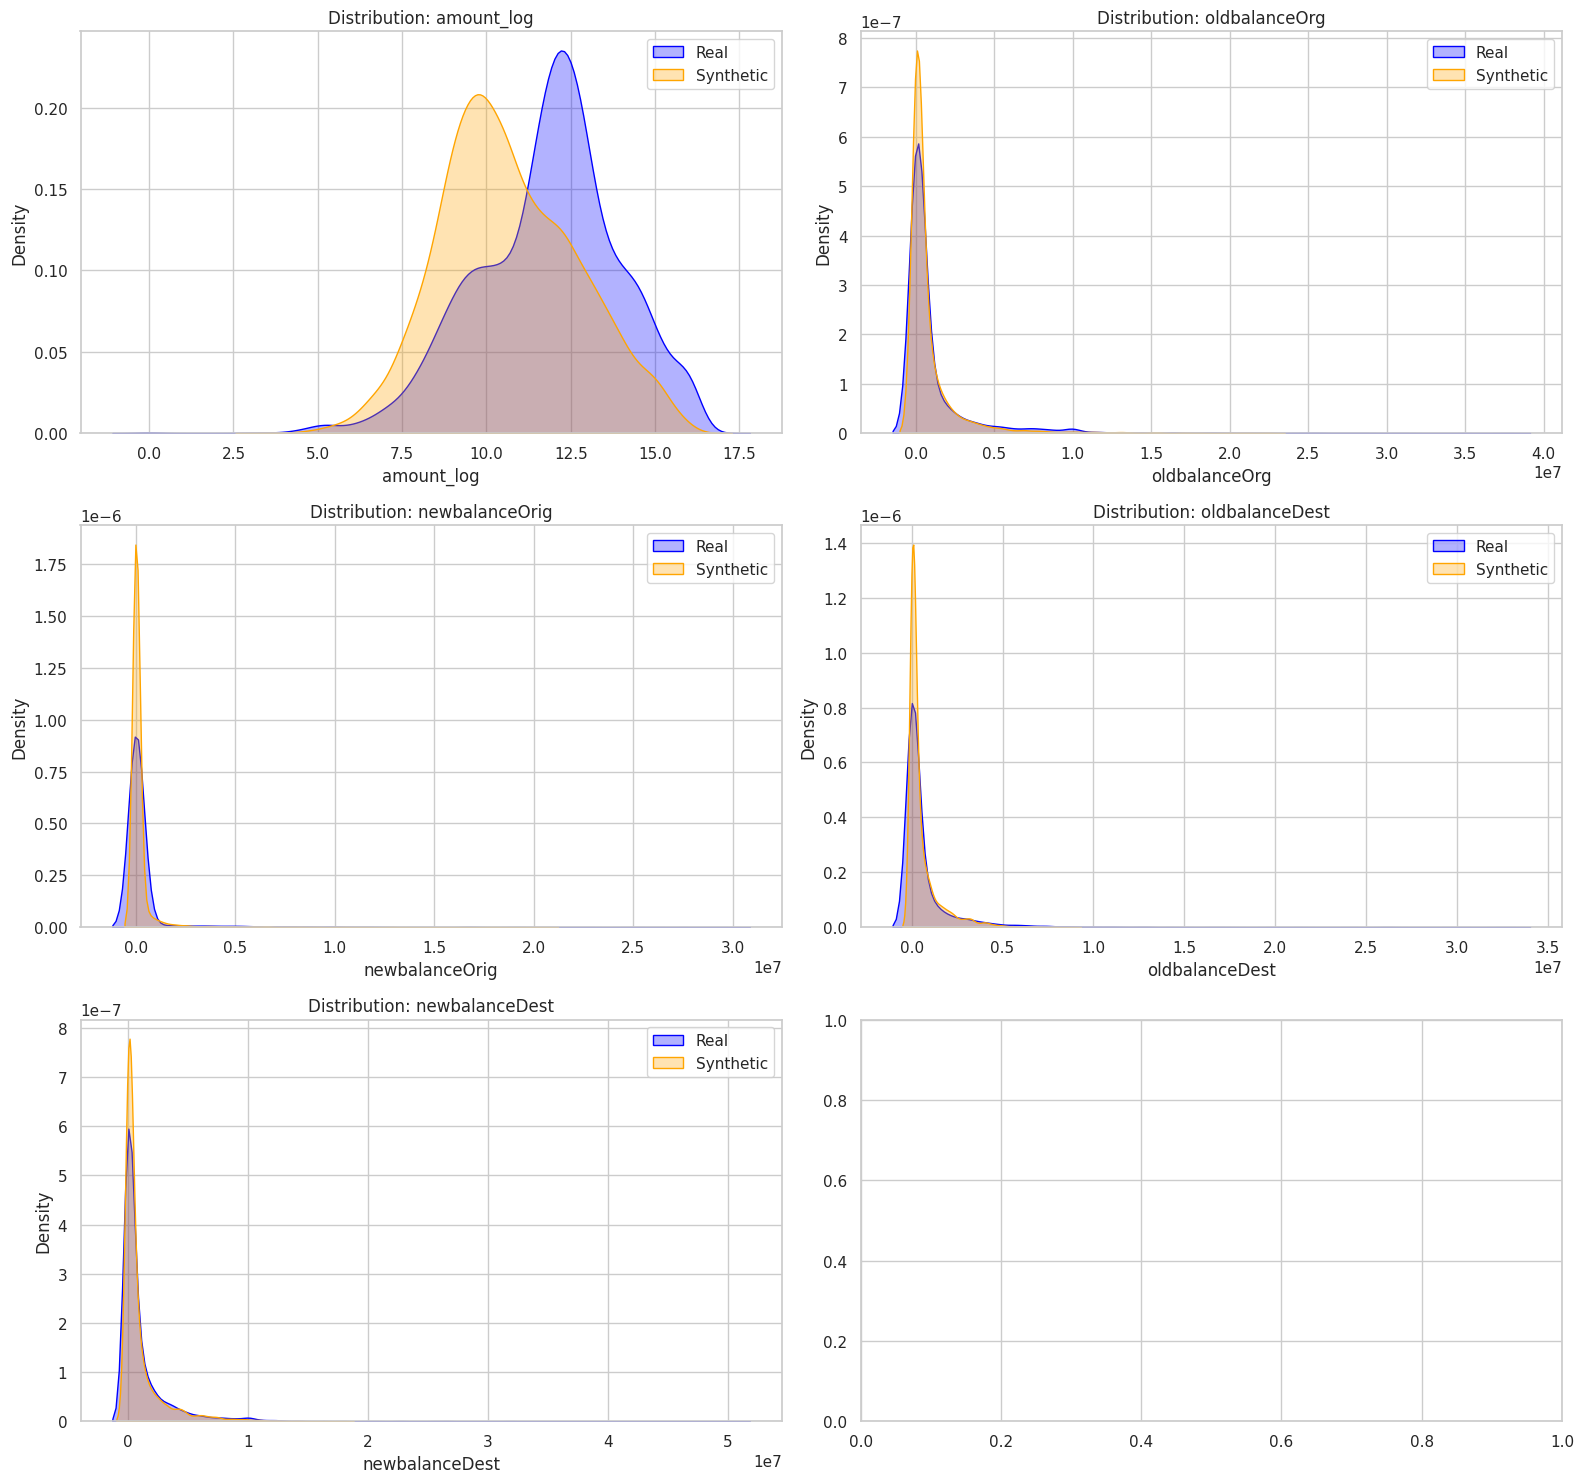

In [7]:
# --- CELL 7: Visual Distribution Plots ---
def plot_feature_distributions(real_df, synthetic_df, columns):
    n_cols = 2
    n_rows = (len(columns) + 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]
        sns.kdeplot(real_df[col], fill=True, label='Real', ax=ax, color='blue', alpha=0.3)
        sns.kdeplot(synthetic_df[col], fill=True, label='Synthetic', ax=ax, color='orange', alpha=0.3)
        ax.set_title(f'Distribution: {col}')
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_feature_distributions(balanced_df, synthetic_df, check_cols)

## Step 7: Utility Testing (TSTR)

In [8]:
# --- CELL 8: Utility Test (TSTR) ---
def run_utility_test(real_df, synthetic_df, feature_cols, target_col):
    """
    Trains on Synthetic, Tests on Real.
    """
    print("--- Starting Utility Test (TSTR) ---")

    # 1. Training Set (Synthetic)
    X_syn = synthetic_df[feature_cols]
    y_syn = synthetic_df[target_col]

    # 2. Testing Set (Real Hold-out)
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        real_df[feature_cols], real_df[target_col], test_size=0.3, random_state=42
    )

    # 3. Train Model
    print(f"Training Random Forest on {len(X_syn)} synthetic records...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_syn, y_syn)

    # 4. Evaluate
    y_pred = rf.predict(X_real_test)
    y_prob = rf.predict_proba(X_real_test)[:, 1]

    auc = roc_auc_score(y_real_test, y_prob)
    print(f"\n✅ ROC-AUC Score on Real Data: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_real_test, y_pred))

# Run Utility Test
run_utility_test(balanced_df, synthetic_df, check_cols, 'isFraud')

--- Starting Utility Test (TSTR) ---
Training Random Forest on 6786 synthetic records...

✅ ROC-AUC Score on Real Data: 0.7827

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.52      0.68      1031
           1       0.67      0.99      0.80      1005

    accuracy                           0.75      2036
   macro avg       0.83      0.76      0.74      2036
weighted avg       0.83      0.75      0.74      2036

